# Taller 3

* Ruben
* Daniel
* Sebastian

**Contexto de negocio:**

El área de fidelización de una empresa de telecomunicaciones tiene como una de sus
metas disminuir la tasa de churn (abandono) por parte de sus clientes. Por esta razón,
desea construir modelos de machine learning que permitan predecir si un cliente es
propenso abandonar los servicios que actualmente tiene contratados con la empresa. Una
vez construidos, estos modelos deben ser disponibilizados a través de una API REST que
pueda ser consumida por la plataforma que es usada por los asesores de call center
usando dicha predicción para ofrecer nuevos productos o servicios a los clientes más
propensos al abandono.

<div style="background-color: blue; height: 2px;"></div>

In [1]:
#!pip install shap
from joblib import dump

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp
from sklearn.feature_selection import chi2

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
import shap
import json
from pprint import pprint

<div style="background-color: blue; height: 2px;"></div>

## Carga y Entendimiento de los datos

Cargar bases de datos churn_future.json y churn_historic.json

In [2]:
# Ruta al archivos JSONs
archivo_json1 = 'churn_future.json'
archivo_json2 = 'churn_historic.json'
# Abre el archivo JSON y carga los datos

with open(archivo_json1, 'r') as archivo1:
    churn_future_json = json.load(archivo1)

with open(archivo_json2, 'r') as archivo2:
    churn_historic_json = json.load(archivo2)

### Evaluación Base de Datos churn_future_json (Testeo)

Se comienza por transformar la base de datos "churn_future_json" en un DataFrame de Pandas con el fin de simplificar su análisis y aprovechar las funcionalidades que ofrecen las librerias.

In [3]:
df_churn_future = pd.DataFrame(churn_future_json)

In [4]:
df_churn_future.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7795-CFOCW    Male              0      No         No      45           No   
1  9237-HQITU  Female              0      No         No       2          Yes   
2  9305-CDSKC  Female              0      No         No       8          Yes   
3  1452-KIOVK    Male              0      No        Yes      22          Yes   
4  6713-OKOMC  Female              0      No         No      10           No   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL            Yes  ...              Yes   
1                No     Fiber optic             No  ...               No   
2               Yes     Fiber optic             No  ...              Yes   
3               Yes     Fiber optic             No  ...               No   
4  No phone service             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0         Yes          No              No        One year               No   
1          No          No              No  Month-to-month              Yes   
2          No         Yes             Yes  Month-to-month              Yes   
3          No         Yes              No  Month-to-month              Yes   
4          No          No              No  Month-to-month               No   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0  Bank transfer (automatic)          42.30       1840.75    No  
1           Electronic check          70.70        151.65   Yes  
2           Electronic check          99.65         820.5   Yes  
3    Credit card (automatic)          89.10        1949.4    No  
4               Mailed check          29.75         301.9    No  

[5 rows x 21 columns]

Se procede a verificar los tipos de datos en el DataFrame para asegurar que estén en el formato correcto

In [5]:
# Tipos de datos DataFrame
column_data_types = df_churn_future.dtypes
print("Tipos de datos que contiene el DataFrame:")
print(column_data_types)

# Resumen de la cantidad de variables por tipo
data_type_counts = column_data_types.value_counts()
print("\nResumen por tipo:")
print(data_type_counts)

Tipos de datos que contiene el DataFrame:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Resumen por tipo:
object     18
int64       2
float64     1
dtype: int64


La variable "TotalCharges", que representa el costo total generado para el cliente, se transforma en una variable numérica continua.

In [6]:
df_churn_future['TotalCharges'] = pd.to_numeric(df_churn_future['TotalCharges'], errors='coerce')
df_churn_future['TotalCharges'] = df_churn_future['TotalCharges'].astype('float64')

La variable "SeniorCitizen" se transforma en una variable categórica para mejorar su comprensión y análisis.

In [7]:
df_churn_future['SeniorCitizen'] = df_churn_future['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

EDA con pandas_profiling: Biblioteca de Python que automatiza y simplifica el proceso de análisis exploratorio de datos (EDA) al generar informes detallados a partir de un DataFrame de pandas. Ofrece estadísticas resumidas, identificación de valores faltantes, visualizaciones de distribuciones y relaciones, matrices de correlación, tablas de frecuencia y más. 

In [8]:
from pandas_profiling import ProfileReport
profile_new = ProfileReport(df_churn_future)
profile_new.to_notebook_iframe()

numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
`import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Filtrar df_churn_historic por tenure igual a 0
filtered_df = df_churn_future[df_churn_future['tenure'] == 0]
num_records = filtered_df.shape[0]
print(num_records)

1


In [10]:
filtered_df

customerID gender SeniorCitizen Partner Dependents  tenure PhoneService  \
179  4367-NUYAO   Male            No     Yes        Yes       0          Yes   

    MultipleLines InternetService       OnlineSecurity  ...  \
179           Yes              No  No internet service  ...   

        DeviceProtection          TechSupport          StreamingTV  \
179  No internet service  No internet service  No internet service   

         StreamingMovies  Contract PaperlessBilling PaymentMethod  \
179  No internet service  Two year               No  Mailed check   

    MonthlyCharges  TotalCharges  Churn  
179          25.75           NaN     No  

[1 rows x 21 columns]

In [11]:
# Filtrar df_churn_future por tenure igual a 0, PhoneService igual a 'No' y InternetService igual a 'No'
filtered_df2 = df_churn_future[(df_churn_future['tenure'] == 0) & (df_churn_future['PhoneService'] == 'No') & (df_churn_future['InternetService'] == 'No')]
num_records = filtered_df2.shape[0]
print(num_records)

0


In [12]:
# Filtrar df_churn_future por PhoneService igual a 'No' y InternetService igual a 'No'
filtered_df3 = df_churn_future[(df_churn_future['PhoneService'] == 'No') & (df_churn_future['InternetService'] == 'No')]
num_records = filtered_df3.shape[0]
print(num_records)

0


* **Dimensiones del DataFrame:**

In [13]:
# Dimensiones DataFrame:
DimR = df_churn_future.shape[0]
DimC = df_churn_future.shape[1]
DimG = df_churn_future.shape
print("El DataFrame cuenta con",DimR,"Filas y",DimC,"Columnas.",DimG)

El DataFrame cuenta con 1000 Filas y 21 Columnas. (1000, 21)


* **Tipos de datos que contiene el DataFrame:**

In [14]:
# Tipos de datos DataFrame
column_data_types = df_churn_future.dtypes
print("Tipos de datos que contiene el DataFrame:")
print(column_data_types)

# Resumen de la cantidad de variables por tipo
data_type_counts = column_data_types.value_counts()
print("\nResumen por tipo:")
print(data_type_counts)

Tipos de datos que contiene el DataFrame:
customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Resumen por tipo:
object     18
float64     2
int64       1
dtype: int64


* **Calidad y Limpiza de Datos:**

Antes de determinar las variables o atributos más importantes, se lleva a cabo un proceso de limpieza en el conjunto de datos con el fin de buscar una mayor eficiencia y precisión en el análisis de las variables relevantes.

**- Duplicados**: Se ejecuta un comando para eliminar registros duplicados del DataFrame con el objetivo de asegurar la integridad y consistencia de los datos, evitando la redundancia de información que podría distorsionar los resultados del análisis

In [15]:
# Antes de eliminar duplicados
num_registros_antes = df_churn_future.shape[0]

# Eliminar duplicados
gapminder =df_churn_future.drop_duplicates()

# Después de eliminar duplicados
num_registros_despues = df_churn_future.shape[0]

# Calcular el número de duplicados eliminados
num_duplicados_eliminados = num_registros_antes - num_registros_despues

# Imprimir el número de duplicados eliminados
print(f'Se eliminaron {num_duplicados_eliminados} registros duplicados.')

Se eliminaron 0 registros duplicados.


**-  Completitud**: El objetivo es verificar la integridad de los datos, evaluando la cantidad de registros faltantes en cada columna. Aquellas columnas que presenten un porcentaje de valores nulos superior al 8% serán excluidas del análisis, siguiendo la recomendación establecida para el curso.

In [16]:
#Identificar Columnas vacias y datos incompletos 

# Contar la cantidad total de registros en el DataFrame
total_registros = len(df_churn_future)

# Contar la cantidad de registros nulos en cada columna
registros_nulos_por_columna = df_churn_future.isnull().sum()

# Calcular la frecuencia relativa de valores nulos en cada columna en términos porcentuales
frecuencia_relativa = (registros_nulos_por_columna / total_registros) * 100

umbral_relevancia = 8

# Crear un nuevo DataFrame con los resultados
resultados_df = pd.DataFrame({
    "Columnas": df_churn_future.columns,
    "Cantidad de Registros Nulos": registros_nulos_por_columna,
    "Frecuencia Relativa (%)": frecuencia_relativa,
    "Relevancia": ["No relevante" if x > umbral_relevancia else "Relevante" for x in frecuencia_relativa]
})


# Formatear el DataFrame como una cadena de texto
tabla_resultados = resultados_df.to_string(index=False)

# Filtrar las columnas no relevantes
columnas_descartadas = resultados_df[resultados_df["Relevancia"] == "No relevante"]["Columnas"].tolist()

# Imprimir la tabla de resultados
print(tabla_resultados)
print("\nColumnas Descartadas:")
print(columnas_descartadas)

        Columnas  Cantidad de Registros Nulos  Frecuencia Relativa (%) Relevancia
      customerID                            0                      0.0  Relevante
          gender                            0                      0.0  Relevante
   SeniorCitizen                            0                      0.0  Relevante
         Partner                            0                      0.0  Relevante
      Dependents                            0                      0.0  Relevante
          tenure                            0                      0.0  Relevante
    PhoneService                            0                      0.0  Relevante
   MultipleLines                            0                      0.0  Relevante
 InternetService                            0                      0.0  Relevante
  OnlineSecurity                            0                      0.0  Relevante
    OnlineBackup                            0                      0.0  Relevante
DeviceProtection

In [17]:
df_churn_future[df_churn_future['TotalCharges'].isnull()]

customerID gender SeniorCitizen Partner Dependents  tenure PhoneService  \
179  4367-NUYAO   Male            No     Yes        Yes       0          Yes   

    MultipleLines InternetService       OnlineSecurity  ...  \
179           Yes              No  No internet service  ...   

        DeviceProtection          TechSupport          StreamingTV  \
179  No internet service  No internet service  No internet service   

         StreamingMovies  Contract PaperlessBilling PaymentMethod  \
179  No internet service  Two year               No  Mailed check   

    MonthlyCharges  TotalCharges  Churn  
179          25.75           NaN     No  

[1 rows x 21 columns]

In [18]:
df_churn_future["TotalCharges"].fillna(0, inplace=True)

**- Consistencia:** Coherencia y uniformidad de los datos en términos de formato, estructura y contenido 

In [19]:
unique_values_per_column = {}

for column in df_churn_future.columns:
    unique_values_per_column[column] = df_churn_future[column].unique()

# Imprimir los valores únicos de cada columna de manera organizada
for column, unique_values in unique_values_per_column.items():
    print(f"Valores únicos en la columna '{column}':")
    for value in unique_values:
        print(f" - {value}")
    print()  # Agregar una línea en blanco para separar las columnas

Valores únicos en la columna 'customerID':
 - 7795-CFOCW
 - 9237-HQITU
 - 9305-CDSKC
 - 1452-KIOVK
 - 6713-OKOMC
 - 7892-POOKP
 - 6388-TABGU
 - 9763-GRSKD
 - 7469-LKBCI
 - 8091-TTVAX
 - 0280-XJGEX
 - 5129-JLPIS
 - 3655-SNQYZ
 - 8191-XWSZG
 - 9959-WOFKT
 - 4190-MFLUW
 - 4183-MYFRB
 - 8779-QRDMV
 - 1680-VDCWW
 - 1066-JKSGK
 - 3638-WEABW
 - 6322-HRPFA
 - 6865-JZNKO
 - 6467-CHFZW
 - 8665-UTDHZ
 - 5248-YGIJN
 - 8773-HHUOZ
 - 3841-NFECX
 - 4929-XIHVW
 - 6827-IEAUQ
 - 7310-EGVHZ
 - 3413-BMNZE
 - 6234-RAAPL
 - 6047-YHPVI
 - 6572-ADKRS
 - 5380-WJKOV
 - 8168-UQWWF
 - 8865-TNMNX
 - 9489-DEDVP
 - 9867-JCZSP
 - 4671-VJLCL
 - 4080-IIARD
 - 3714-NTNFO
 - 5948-UJZLF
 - 7760-OYPDY
 - 7639-LIAYI
 - 2954-PIBKO
 - 8012-SOUDQ
 - 9420-LOJKX
 - 6575-SUVOI
 - 7495-OOKFY
 - 4667-QONEA
 - 1658-BYGOY
 - 8769-KKTPH
 - 5067-XJQFU
 - 3957-SQXML
 - 5954-BDFSG
 - 0434-CSFON
 - 1215-FIGMP
 - 0526-SXDJP
 - 0557-ASKVU
 - 5698-BQJOH
 - 5122-CYFXA
 - 8627-ZYGSZ
 - 3410-YOQBQ
 - 3170-NMYVV
 - 7410-OIEDU
 - 2273-QCKXA
 - 07

La informació se ajusta a los niveles de las variables descritas en el documento.

**- Relevancia:** Información adecuada para respaldar los requisitos (análisis de variables no numéricas).

La variable "customerID", que corresponde al identificador del cliente, se considera de poca relevancia en la creación de un modelo de machine learning, ya que previamente se verificó que no existen registros duplicados para el mismo cliente, lo que la hace irrelevante en el análisis y se procede a su eleminación.

In [20]:
df_churn_future = df_churn_future.drop("customerID", axis=1)

<div style="background-color: skyblue; height: 2px;"></div>

### Evaluación Base de Datos churn_historic_json

Se comienza por transformar la base de datos "churn_historic_json" en un DataFrame de Pandas con el fin de simplificar su análisis y aprovechar las funcionalidades que ofrecen las librerias.

In [21]:
df_churn_historic = pd.DataFrame(churn_historic_json)

In [22]:
df_churn_historic.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  5386-THSLQ  Female              1     Yes         No      66           No   
4  3192-NQECA    Male              0     Yes         No      68          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL             No  ...              Yes   
4               Yes     Fiber optic             No  ...              Yes   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3          No         Yes              No        One year               No   
4         Yes         Yes             Yes        Two year              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          45.55       3027.25    No  
4  Bank transfer (automatic)         110.00       7611.85   Yes  

[5 rows x 21 columns]

Se procede a verificar los tipos de datos en el DataFrame para asegurar que estén en el formato correcto

In [23]:
# Tipos de datos DataFrame
column_data_types = df_churn_historic.dtypes
print("Tipos de datos que contiene el DataFrame:")
print(column_data_types)

# Resumen de la cantidad de variables por tipo
data_type_counts = column_data_types.value_counts()
print("\nResumen por tipo:")
print(data_type_counts)

Tipos de datos que contiene el DataFrame:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Resumen por tipo:
object     18
int64       2
float64     1
dtype: int64


La variable "TotalCharges", que representa el costo total generado para el cliente, se transforma en una variable numérica continua.

In [24]:
df_churn_historic['TotalCharges'] = pd.to_numeric(df_churn_historic['TotalCharges'], errors='coerce')
df_churn_historic['TotalCharges'] = df_churn_historic['TotalCharges'].astype('float64')


La variable "SeniorCitizen" se transforma en una variable categórica para mejorar su comprensión y análisis.

In [25]:
df_churn_historic['SeniorCitizen'] = df_churn_historic['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

EDA con pandas_profiling: Biblioteca de Python que automatiza y simplifica el proceso de análisis exploratorio de datos (EDA) al generar informes detallados a partir de un DataFrame de pandas. Ofrece estadísticas resumidas, identificación de valores faltantes, visualizaciones de distribuciones y relaciones, matrices de correlación, tablas de frecuencia y más. 

In [26]:
from pandas_profiling import ProfileReport
profile_new = ProfileReport(df_churn_historic)
profile_new.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
# Filtrar df_churn_historic por tenure igual a 0
filtered_df = df_churn_historic[df_churn_historic['tenure'] == 0]


In [28]:
from pandas_profiling import ProfileReport
profile_new = ProfileReport(filtered_df)
profile_new.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
# Filtrar df_churn_historic por tenure igual a 0, PhoneService igual a 'No' y InternetService igual a 'No'
filtered_df2 = df_churn_historic[(df_churn_historic['tenure'] == 0) & (df_churn_historic['PhoneService'] == 'No') & (df_churn_historic['InternetService'] == 'No')]
num_records = filtered_df2.shape[0]
print(num_records)

0


In [30]:
# Filtrar df_churn_historic por PhoneService igual a 'No' y InternetService igual a 'No'
filtered_df3 = df_churn_historic[(df_churn_historic['PhoneService'] == 'No') & (df_churn_historic['InternetService'] == 'No')]
num_records = filtered_df3.shape[0]
print(num_records)

0


* **Dimensiones del DataFrame:**

In [31]:
# Dimensiones DataFrame:
DimR = df_churn_historic.shape[0]
DimC = df_churn_historic.shape[1]
DimG = df_churn_historic.shape
print("El DataFrame cuenta con",DimR,"Filas y",DimC,"Columnas.",DimG)

El DataFrame cuenta con 6000 Filas y 21 Columnas. (6000, 21)


* **Tipos de datos que contiene el DataFrame:**

In [32]:
# Tipos de datos DataFrame
column_data_types = df_churn_historic.dtypes
print("Tipos de datos que contiene el DataFrame:")
print(column_data_types)

# Resumen de la cantidad de variables por tipo
data_type_counts = column_data_types.value_counts()
print("\nResumen por tipo:")
print(data_type_counts)

Tipos de datos que contiene el DataFrame:
customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Resumen por tipo:
object     18
float64     2
int64       1
dtype: int64


* **Calidad y Limpiza de Datos:**

Antes de determinar las variables o atributos más importantes, se lleva a cabo un proceso de limpieza en el conjunto de datos con el fin de buscar una mayor eficiencia y precisión en el análisis de las variables relevantes

**- Duplicados**: Se ejecuta un comando para eliminar registros duplicados del DataFrame con el objetivo de asegurar la integridad y consistencia de los datos, evitando la redundancia de información que podría distorsionar los resultados del análisis

In [33]:
# Antes de eliminar duplicados
num_registros_antes = df_churn_historic.shape[0]

# Eliminar duplicados
gapminder =df_churn_historic.drop_duplicates()

# Después de eliminar duplicados
num_registros_despues = df_churn_historic.shape[0]

# Calcular el número de duplicados eliminados
num_duplicados_eliminados = num_registros_antes - num_registros_despues

# Imprimir el número de duplicados eliminados
print(f'Se eliminaron {num_duplicados_eliminados} registros duplicados.')

Se eliminaron 0 registros duplicados.


**-  Completitud**: El objetivo es verificar la integridad de los datos, evaluando la cantidad de registros faltantes en cada columna. Aquellas columnas que presenten un porcentaje de valores nulos superior al 8% serán excluidas del análisis, siguiendo la recomendación establecida para el curso.

In [34]:
#Identificar Columnas vacias y datos incompletos 

# Contar la cantidad total de registros en el DataFrame
total_registros = len(df_churn_historic)

# Contar la cantidad de registros nulos en cada columna
registros_nulos_por_columna = df_churn_historic.isnull().sum()

# Calcular la frecuencia relativa de valores nulos en cada columna en términos porcentuales
frecuencia_relativa = (registros_nulos_por_columna / total_registros) * 100

umbral_relevancia = 8

# Crear un nuevo DataFrame con los resultados
resultados_df = pd.DataFrame({
    "Columnas": df_churn_historic.columns,
    "Cantidad de Registros Nulos": registros_nulos_por_columna,
    "Frecuencia Relativa (%)": frecuencia_relativa,
    "Relevancia": ["No relevante" if x > umbral_relevancia else "Relevante" for x in frecuencia_relativa]
})


# Formatear el DataFrame como una cadena de texto
tabla_resultados = resultados_df.to_string(index=False)

# Filtrar las columnas no relevantes
columnas_descartadas = resultados_df[resultados_df["Relevancia"] == "No relevante"]["Columnas"].tolist()

# Imprimir la tabla de resultados
print(tabla_resultados)
print("\nColumnas Descartadas:")
print(columnas_descartadas)

        Columnas  Cantidad de Registros Nulos  Frecuencia Relativa (%) Relevancia
      customerID                            0                 0.000000  Relevante
          gender                            0                 0.000000  Relevante
   SeniorCitizen                            0                 0.000000  Relevante
         Partner                            0                 0.000000  Relevante
      Dependents                            0                 0.000000  Relevante
          tenure                            0                 0.000000  Relevante
    PhoneService                            0                 0.000000  Relevante
   MultipleLines                            0                 0.000000  Relevante
 InternetService                            0                 0.000000  Relevante
  OnlineSecurity                            0                 0.000000  Relevante
    OnlineBackup                            0                 0.000000  Relevante
DeviceProtection

In [35]:
df_churn_historic[df_churn_historic['TotalCharges'].isnull()]

customerID  gender SeniorCitizen Partner Dependents  tenure  \
288   4472-LVYGI  Female            No     Yes        Yes       0   
553   3115-CZMZD    Male            No      No        Yes       0   
736   5709-LVOEQ  Female            No     Yes        Yes       0   
1040  1371-DWPAZ  Female            No     Yes        Yes       0   
2831  7644-OMVMY    Male            No     Yes        Yes       0   
3215  3213-VVOLG    Male            No     Yes        Yes       0   
3669  2520-SGTTA  Female            No     Yes        Yes       0   
4507  2923-ARZLG    Male            No     Yes        Yes       0   
5859  4075-WKNIU  Female            No     Yes        Yes       0   
5943  2775-SEFEE    Male            No      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
288            No  No phone service             DSL                  Yes  ...   
553           Yes                No              No  No internet service  ...   
736           Yes                No             DSL                  Yes  ...   
1040           No  No phone service             DSL                  Yes  ...   
2831          Yes                No              No  No internet service  ...   
3215          Yes               Yes              No  No internet service  ...   
3669          Yes                No              No  No internet service  ...   
4507          Yes                No              No  No internet service  ...   
5859          Yes               Yes             DSL                   No  ...   
5943          Yes               Yes             DSL                  Yes  ...   

         DeviceProtection          TechSupport          StreamingTV  \
288                   Yes                  Yes                  Yes   
553   No internet service  No internet service  No internet service   
736                   Yes                   No                  Yes   
1040                  Yes                  Yes                  Yes   
2831  No internet service  No internet service  No internet service   
3215  No internet service  No internet service  No internet service   
3669  No internet service  No internet service  No internet service   
4507  No internet service  No internet service  No internet service   
5859                  Yes                  Yes                  Yes   
5943                   No                  Yes                   No   

          StreamingMovies  Contract PaperlessBilling  \
288                    No  Two year              Yes   
553   No internet service  Two year               No   
736                   Yes  Two year               No   
1040                   No  Two year               No   
2831  No internet service  Two year               No   
3215  No internet service  Two year               No   
3669  No internet service  Two year               No   
4507  No internet service  One year              Yes   
5859                   No  Two year               No   
5943                   No  Two year              Yes   

                  PaymentMethod MonthlyCharges  TotalCharges  Churn  
288   Bank transfer (automatic)          52.55           NaN     No  
553                Mailed check          20.25           NaN     No  
736                Mailed check          80.85           NaN     No  
1040    Credit card (automatic)          56.05           NaN     No  
2831               Mailed check          19.85           NaN     No  
3215               Mailed check          25.35           NaN     No  
3669               Mailed check          20.00           NaN     No  
4507               Mailed check          19.70           NaN     No  
5859               Mailed check          73.35           NaN     No  
5943  Bank transfer (automatic)          61.90           NaN     No  

[10 rows x 21 columns]

In [36]:
df_churn_historic["TotalCharges"].fillna(0, inplace=True)

**- Consistencia:** Coherencia y uniformidad de los datos en términos de formato, estructura y contenido 

In [37]:
unique_values_per_column = {}

for column in df_churn_historic.columns:
    unique_values_per_column[column] = df_churn_historic[column].unique()

# Imprimir los valores únicos de cada columna de manera organizada
for column, unique_values in unique_values_per_column.items():
    print(f"Valores únicos en la columna '{column}':")
    for value in unique_values:
        print(f" - {value}")
    print()  # Agregar una línea en blanco para separar las columnas

Valores únicos en la columna 'customerID':
 - 7590-VHVEG
 - 5575-GNVDE
 - 3668-QPYBK
 - 5386-THSLQ
 - 3192-NQECA
 - 6180-YBIQI
 - 6728-DKUCO
 - 9750-BOOHV
 - 8597-CWYHH
 - 2848-YXSMW
 - 0486-HECZI
 - 4549-ZDQYY
 - 5712-AHQNN
 - 4846-WHAFZ
 - 5256-SKJGO
 - 3071-VBYPO
 - 9560-BBZXK
 - 5299-RULOA
 - 8402-OOOHJ
 - 9445-ZUEQE
 - 1091-SOZGA
 - 2928-HLDBA
 - 0404-SWRVG
 - 6497-TILVL
 - 7219-TLZHO
 - 4622-YNKIJ
 - 4412-YLTKF
 - 6734-PSBAW
 - 3930-ZGWVE
 - 2639-UGMAZ
 - 2876-GZYZC
 - 6207-WIOLX
 - 8587-XYZSF
 - 3091-FYHKI
 - 2372-HWUHI
 - 7799-LGRDP
 - 7850-VWJUU
 - 3774-VBNXY
 - 6217-KDYWC
 - 0390-DCFDQ
 - 3146-MSEGF
 - 4080-OGPJL
 - 1095-WGNGG
 - 2636-SJDOU
 - 1131-QQZEB
 - 5716-EZXZN
 - 6837-BJYDQ
 - 2135-RXIHG
 - 6440-DKQGE
 - 3466-BYAVD
 - 3780-YVMFA
 - 3874-EQOEP
 - 1679-JRFBR
 - 9073-ZZIAY
 - 3077-RSNTJ
 - 6551-GNYDG
 - 9167-APMXZ
 - 2749-CTKAJ
 - 6371-NZYEG
 - 7554-NEWDD
 - 8992-VONJD
 - 0867-MKZVY
 - 4482-EWFMI
 - 4648-YPBTM
 - 2907-ILJBN
 - 6345-FZOQH
 - 3376-BMGFE
 - 5997-OPVFA
 - 34

La informació se ajusta a los niveles de las variables descritas en el documento.

**- Relevancia:** Información adecuada para respaldar los requisitos (análisis de variables no numéricas).

La variable "customerID", que corresponde al identificador del cliente, se considera de poca relevancia en la creación de un modelo de machine learning, ya que previamente se verificó que no existen registros duplicados para el mismo cliente, lo que la hace irrelevante en el análisis y se procede a su eleminación.

In [38]:
df_churn_historic = df_churn_historic.drop("customerID", axis=1)

## Conclusiones Carga y Entendimiento de los datos

Se ha llevado a cabo una exhaustiva revisión de las bases de datos "churn_future.json" y "churn_historic.json". Se ha confirmado que no existen registros duplicados ni registros dobles para un mismo cliente en ambas bases de datos.

En el proceso de análisis, se evaluaron los registros en los cuales la duración de la permanencia del cliente, representada por la variable "tenure", fuera igual a 0. Esto se hizo como un criterio inicial de sospecha de posibles errores. Sin embargo, tras un análisis más detenido, se determinó que estos registros corresponden a clientes que recientemente se incorporaron a la base de datos, lo que justifica esta condición.

Se observó que la totalidad de los registros está completo, con la excepción de algunos registros en la variable "TotalCharges" en ambas bases de datos. No obstante, esta falta de datos se relaciona directamente con la duración de los clientes, es decir, aquellos con una duración ("tenure") igual a 0. En estos casos, los valores nulos se han imputado con el valor 0, ya que esto indica que no se han realizado cargos a esos clientes aún.

También se verificó que no existen clientes registrados que no cuenten con servicios de internet ni telefonía, lo cual es coherente con la naturaleza de la empresa de telecomunicaciones. En resumen, ambas bases de datos presentan una alta calidad en sus datos.

En una primera evaluación, se ha descartado la utilización de la variable "customerID" en el análisis, ya que no aporta valor y se ha corroborado que no existen registros duplicados de clientes.

<div style="background-color: skyblue; height: 2px;"></div>

## Analisis de las features y su relación con la variable objetivo

Con el propósito de identificar las características que deben ser consideradas en la construcción de un Pipeline, se realiza un análisis exhaustivo de su relación con la variable de interés, "Churn". Además, se aplican dos pruebas estadísticas, Kolmogorov-Smirnov (KS) para características numéricas y Chi2 para características categóricas, con el objetivo de determinar su relevancia empíricamente.

En el caso de la prueba Kolmogorov-Smirnov (KS), se utiliza debido a su naturaleza no paramétrica, lo que significa que no es necesario que los datos sigan una distribución normal. Esta prueba nos proporciona un valor estadístico y un p-valor que permiten determinar si existe una diferencia significativa entre la distribución de la variable para las clases positivas y negativas. Si el valor del estadístico KS es bajo, indica que las distribuciones son similares, lo que no es relevante para nuestro análisis.

Por otro lado, cuando tratamos con características categóricas, se aplica un proceso conocido como codificación one-hot (one-hot encoding) antes de la prueba Chi2. La prueba Chi2 evalúa la relación entre una característica categórica específica y su impacto en la variable de interés, es decir, si hay una relación significativa entre un valor particular de la característica y la clasificación en las clases positivas o negativas. Un valor alto en la estadística Chi2 indica una mayor diferencia en la relación entre la característica categórica y la variable de interés, lo que sugiere una mayor relevancia de dicha característica en el análisis.

En resumen, a través de estas pruebas, determinamos la importancia de las características tanto numéricas como categóricas en relación con la variable "Churn" y evaluamos si existen diferencias significativas en sus distribuciones o relaciones, lo que contribuye a la toma de decisiones informadas en la construcción del Pipeline.

En este proceso, se hará uso exclusivamente del DataFrame histórico, que servirá como conjunto de entrenamiento para el modelo. Posteriormente, este modelo será validado y probado utilizando el DataFrame que contiene registros futuros.

* **Balanceo:**

Se realiza una evaluación de la proporción de registros para las clases positivas (Yes) y negativas (No).

In [39]:
df_churn_historic["Churn"].value_counts(dropna=False, normalize=True)

No     0.734667
Yes    0.265333
Name: Churn, dtype: float64

Basándonos en los resultados, se puede concluir que la variable "Churn" presenta una proporción desigual entre las clases "No" y "Yes". La clase "No" representa aproximadamente el 73.47% de los registros, mientras que la clase "Yes" representa aproximadamente el 26.53%.Es importante tener en cuenta que un desequilibrio significativo en la proporción de clases puede afectar el rendimiento del modelo. 

* **Distribución de las variables numericas entre clase positiva y negativa:** 

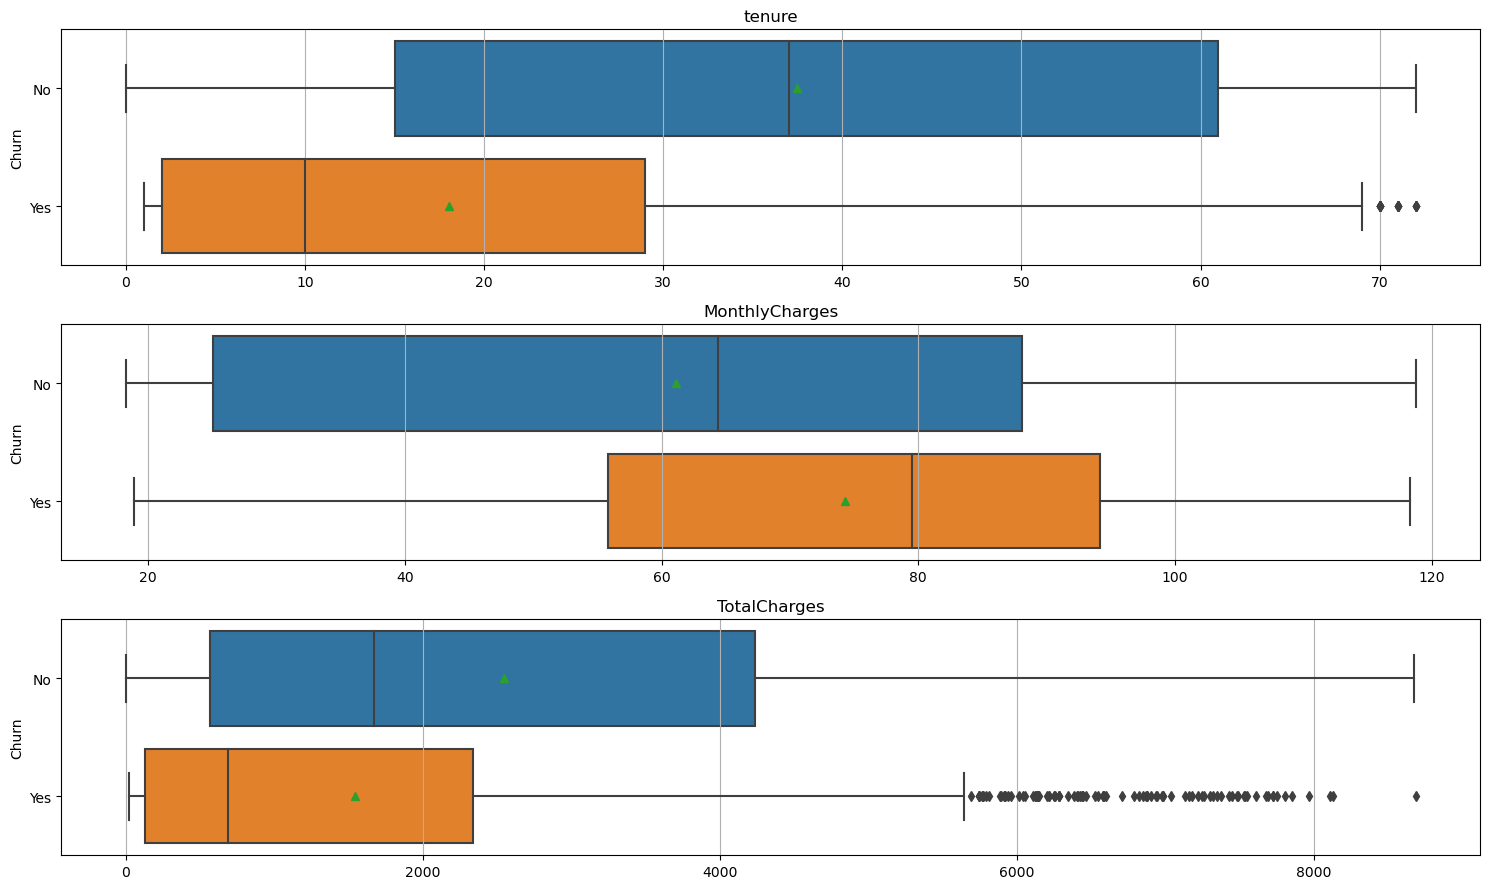

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Filtrar solo las columnas numéricas
numeric_columns = df_churn_historic.select_dtypes(include=['number'])

# Establecer el tamaño de la figura
fig, axes = plt.subplots(len(numeric_columns.columns), 1, figsize=(15, 3 * len(numeric_columns.columns)))

# Iterar a través de las columnas numéricas y crear gráficos boxplot
for i, column in enumerate(numeric_columns.columns):
    sns.boxplot(data=df_churn_historic, x=column, y="Churn", showmeans=True, orient="h", ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Churn')
    axes[i].grid(axis='x')

# Ajustar la disposición de las gráficas
plt.tight_layout()
plt.show()


Aparentemente, las tres variables numéricas resultan relevantes, ya que muestran diferencias en la distribución de los datos según la clasificación en las clases positivas o negativas.

* **Distribución de las variables categoricas entre clase positiva y negativa:** 

In [41]:
# Obtén la lista de columnas categóricas
categorical_columns = df_churn_historic.select_dtypes(include=['object']).columns

# Filtra las columnas numéricas y exclúyelas de la lista
numeric_columns = df_churn_historic.select_dtypes(include=['number']).columns
categorical_columns = categorical_columns.difference(numeric_columns)

# Crea un diccionario para almacenar las tablas cruzadas
crosstab_dict = {}

# Itera a través de las columnas categóricas y crea las tablas cruzadas
for column in categorical_columns:
    crosstab = pd.crosstab(df_churn_historic["Churn"], df_churn_historic[column], normalize="columns")
    crosstab_dict[column] = crosstab

# Ahora crosstab_dict contiene las tablas cruzadas solo para columnas categóricas
for column, crosstab in crosstab_dict.items():
    print(f"Tabla Cruzada para la columna '{column}':")
    print(crosstab)
    print("\n")



Tabla Cruzada para la columna 'Churn':
Churn   No  Yes
Churn          
No     1.0  0.0
Yes    0.0  1.0


Tabla Cruzada para la columna 'Contract':
Contract  Month-to-month  One year  Two year
Churn                                       
No              0.574552   0.88141  0.970528
Yes             0.425448   0.11859  0.029472


Tabla Cruzada para la columna 'Dependents':
Dependents       No       Yes
Churn                        
No          0.68465  0.850359
Yes         0.31535  0.149641


Tabla Cruzada para la columna 'DeviceProtection':
DeviceProtection        No  No internet service       Yes
Churn                                                    
No                0.603817             0.926236  0.778692
Yes               0.396183             0.073764  0.221308


Tabla Cruzada para la columna 'InternetService':
InternetService       DSL  Fiber optic        No
Churn                                           
No               0.808831     0.580412  0.926236
Yes              0.191169

* Contrato (Contract): Los clientes con contratos a corto plazo (Month-to-month) tienen una tasa de abandono (Churn) más alta en comparación con los contratos a largo plazo (One year y Two year), donde la tasa de abandono disminuye significativamente.

* Dependientes (Dependents): Los clientes sin dependientes (No) tienden a tener una tasa de abandono más alta en comparación con aquellos que tienen dependientes (Yes).

* Protección de Dispositivo (DeviceProtection): Los clientes que no tienen servicio de protección de dispositivo (No) tienen una tasa de abandono más alta en comparación con aquellos que tienen (Yes). Además, la tasa de abandono es muy baja para aquellos que no tienen servicio de Internet.

* Tipo de Servicio de Internet (InternetService): Los clientes con servicio de fibra óptica (Fiber optic) muestran una tasa de abandono más alta en comparación con los que tienen servicio DSL o no tienen servicio de Internet.

* Líneas Múltiples (MultipleLines): No parece haber una gran diferencia en la tasa de abandono entre aquellos que tienen líneas múltiples (Yes) y los que no las tienen (No).

* Copia de Seguridad en Línea (OnlineBackup) y Seguridad en Línea (OnlineSecurity): Los clientes que no tienen servicio de copia de seguridad en línea ni seguridad en línea tienden a tener una tasa de abandono más alta. Además, la tasa de abandono es muy baja para aquellos que no tienen servicio de Internet.

* Facturación Electrónica (PaperlessBilling): Los clientes con facturación electrónica (Yes) tienen una tasa de abandono más alta en comparación con aquellos que no la tienen (No).

* Socios (Partner): Los clientes sin socios (No) tienen una tasa de abandono más alta en comparación con aquellos que tienen socios (Yes).

* Método de Pago (PaymentMethod): El método de pago influye en la tasa de abandono. Los clientes que utilizan métodos de pago electrónicos (Electronic check) muestran una tasa de abandono más alta en comparación con los métodos de pago automáticos o el pago por correo (Mailed check).

* Servicio de Teléfono (PhoneService): La disponibilidad de servicio de teléfono no parece tener un gran impacto en la tasa de abandono.

* Cliente Senior (SeniorCitizen): Los clientes senior (Yes) tienen una tasa de abandono más alta en comparación con los no senior (No).

* Películas en Streaming (StreamingMovies) y Televisión en Streaming (StreamingTV): Los clientes que no tienen servicio de streaming de películas o televisión tienden a tener una tasa de abandono más alta.

* Soporte Técnico (TechSupport): Los clientes que no tienen servicio de soporte técnico tienden a tener una tasa de abandono más alta.

* Género (gender): No parece haber una gran diferencia en la tasa de abandono entre géneros (Female y Male).

* **Selección Variables Numericas Relevantes (Kolmogorov-Smirnov):**

In [42]:
numeric_columns = df_churn_historic.select_dtypes(include=['number']).columns
numeric_columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [43]:
numerical_features = numeric_columns

In [44]:
ks_results = []
for f in numerical_features:
    ks_stat, p_value = ks_2samp(df_churn_historic.loc[df_churn_historic["Churn"] =="Yes", f], df_churn_historic.loc[df_churn_historic["Churn"] == "No", f])
    ks_results.append({
        "Feature": f,
        "KS stat": ks_stat,
        "p-value": p_value
    })
pd.DataFrame(ks_results)

Feature   KS stat        p-value
0          tenure  0.352330  1.348587e-129
1  MonthlyCharges  0.248452   6.368070e-64
2    TotalCharges  0.221103   1.333608e-50

- Una alta estadística KS (y un pequeño valor de p) indica que las distribuciones de la característica son significativamente diferentes entre las dos clases. Esto sugiere que la característica podría ser discriminatoria y útil para la clasificación.
- Por otro lado, una baja estadística KS (y un valor de p grande) sugiere que la característica tiene una distribución similar en ambas clases y puede que no sea tan informativa.

Como criterio empírico establecido para este curso, se consideran relevantes todas aquellas variables cuyo estadístico sea mayor a 0.1 y, en este caso, las tres evaluadas cumplen con este criterio, por lo que se consideran relevantes para ser incluidas en el modelo.

In [45]:
import pandas as pd
ks_results=pd.DataFrame(ks_results)

filtered_results = ks_results[(ks_results['KS stat'] > 0.1) & (ks_results['p-value'] <= 0.5)]

# Obtener las características únicas de la columna 'Feature' en el DataFrame filtrado
unique_features = filtered_results['Feature'].unique()

# Mostrar las características únicas
print(unique_features)


['tenure' 'MonthlyCharges' 'TotalCharges']


In [46]:
numeric_columns = df_churn_historic.select_dtypes(include=['number']).columns
correlation_matrix = df_churn_historic[numeric_columns].corr()

print(correlation_matrix)


                  tenure  MonthlyCharges  TotalCharges
tenure          1.000000        0.255071      0.827185
MonthlyCharges  0.255071        1.000000      0.654090
TotalCharges    0.827185        0.654090      1.000000


Como criterio establecido en el curso, se ha determinado que cuando dos variables presentan una correlación del 90% o superior, una de ellas debe ser descartada para evitar la multicolinealidad. A pesar de que la matriz de correlación indica una alta correlación entre las variables "Tenure" y "TotalCharges," lo cual es coherente con la intuición, ya que una mayor duración de permanencia del cliente se traduce en mayores cargos totales, se ha decidido conservar ambas variables, ya que no superan el umbral definido. 

* **Selección Variables Categoricas Relevantes (Chi2):**

In [47]:
# Obtén la lista de columnas categóricas
categorical_columns = df_churn_historic.select_dtypes(include=['object']).columns

# Filtra las columnas numéricas y exclúyelas de la lista
numeric_columns = df_churn_historic.select_dtypes(include=['number']).columns
categorical_columns = categorical_columns.difference(numeric_columns)


In [48]:
categorical_features =categorical_columns.drop("Churn")

In [49]:
chi2_results = []
for f in categorical_features:
    onehot = OneHotEncoder(sparse=False)
    t = onehot.fit_transform(df_churn_historic[[f]])
    values = onehot.categories_[0]
    chi2_stats, p_values = chi2(t, df_churn_historic["Churn"])
    
    for value, chi_stat, p_value in zip(values, chi2_stats, p_values):
        chi2_results.append({
            "Feature": f,
            "Value": value,
            "Chi2 stat": chi_stat,
            "p-value": p_value
        })
pd.DataFrame(chi2_results)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

Feature                      Value   Chi2 stat       p-value
0           Contract             Month-to-month  433.083241  3.465982e-96
1           Contract                   One year  137.863949  7.804472e-32
2           Contract                   Two year  416.376062  1.500539e-92
3         Dependents                         No   53.759217  2.266285e-13
4         Dependents                        Yes  124.349729  7.063046e-29
5   DeviceProtection                         No  230.126034  5.595730e-52
6   DeviceProtection        No internet service  247.567943  8.803599e-56
7   DeviceProtection                        Yes   20.533026  5.861121e-06
8    InternetService                        DSL   58.154337  2.423393e-14
9    InternetService                Fiber optic  320.302730  1.244401e-71
10   InternetService                         No  247.567943  8.803599e-56
11     MultipleLines                         No    2.174286  1.403346e-01
12     MultipleLines           No phone service    0.967155  3.253906e-01
13     MultipleLines                        Yes    4.203261  4.034633e-02
14      OnlineBackup                         No  245.132744  2.989416e-55
15      OnlineBackup        No internet service  247.567943  8.803599e-56
16      OnlineBackup                        Yes   25.943473  3.515620e-07
17    OnlineSecurity                         No  358.643544  5.558400e-80
18    OnlineSecurity        No internet service  247.567943  8.803599e-56
19    OnlineSecurity                        Yes  123.360869  1.162592e-28
20  PaperlessBilling                         No  132.583953  1.114908e-30
21  PaperlessBilling                        Yes   94.055283  3.068334e-22
22           Partner                         No   71.157193  3.298679e-17
23           Partner                        Yes   75.912445  2.965253e-18
24     PaymentMethod  Bank transfer (automatic)   67.496871  2.110217e-16
25     PaymentMethod    Credit card (automatic)   92.045960  8.468664e-22
26     PaymentMethod           Electronic check  371.420282  9.182401e-83
27     PaymentMethod               Mailed check   37.463706  9.312994e-10
28      PhoneService                         No    0.967155  3.253906e-01
29      PhoneService                        Yes    0.105475  7.453554e-01
30     SeniorCitizen                         No   22.003655  2.721318e-06
31     SeniorCitizen                        Yes  115.376083  6.510257e-27
32   StreamingMovies                         No   69.669106  7.013605e-17
33   StreamingMovies        No internet service  247.567943  8.803599e-56
34   StreamingMovies                        Yes   11.750437  6.082894e-04
35       StreamingTV                         No   65.639451  5.414401e-16
36       StreamingTV        No internet service  247.567943  8.803599e-56
37       StreamingTV                        Yes   13.335327  2.604526e-04
38       TechSupport                         No  340.145126  5.932870e-76
39       TechSupport        No internet service  247.567943  8.803599e-56
40       TechSupport                        Yes  107.136966  4.154422e-25
41            gender                     Female    0.293849  5.877644e-01
42            gender                       Male    0.284404  5.938289e-01

- Una característica con un alto valor estadístico y un valor p bajo se considera más relevante para la tarea de clasificación porque tiene una asociación significativa con la variable objetivo. Tal característica puede mejorar potencialmente el rendimiento de un clasificador.

- Por el contrario, una característica con un valor estadístico bajo y un valor p alto podría no ser muy informativa para la tarea de clasificación, ya que no parece tener una relación sólida con la variable objetivo

Las variables que tengan al menos un nivel con un estadístico superior a 100 se incluirán en el modelo como definición empírica del curso.

Se presentan las variables Categoricas que cumplen con el criterio mencionado anteriormente

In [50]:
import pandas as pd
chi2_results=pd.DataFrame(chi2_results)
# Supongamos que tienes un DataFrame chi2_results con una columna 'Chi2_stat' y una columna 'Feature'
# Filtrar por resultados Chi2_stat > 100
filtered_results = chi2_results[chi2_results['Chi2 stat'] > 100]

# Obtener las características únicas de la columna 'Feature' en el DataFrame filtrado
unique_features = filtered_results['Feature'].unique()

# Mostrar las características únicas
print(unique_features)


['Contract' 'Dependents' 'DeviceProtection' 'InternetService'
 'OnlineBackup' 'OnlineSecurity' 'PaperlessBilling' 'PaymentMethod'
 'SeniorCitizen' 'StreamingMovies' 'StreamingTV' 'TechSupport']


<div style="background-color: blue; height: 2px;"></div>

### 1. [20%] Integración del proceso de transformación de datos, entrenamiento y predicción: 
Utilizando la función Pipeline de Scikit-Learn, encapsule los procesos
secuenciales de transformación, entrenamiento y predicción requeridos para dar
solución al problema planteado. Tenga en cuenta que a partir de los datos
originales el pipeline debe estar en capacidad de realizar todas las
transformaciones de datos necesarias para realizar las labores de entrenamiento y
predicción. Es decir, posterior a las fases de exploración y análisis de calidad de los
datos, no se deben implementar procesos de transformación de datos por fuera
del pipeline.

Con base en el punto anterior se definen las funciones para Transformar la Base de datos Original y Construir el Pipeline

In [51]:
features = ["tenure", "MonthlyCharges", "TotalCharges","Contract", "Dependents", "DeviceProtection", "InternetService", "OnlineBackup", "OnlineSecurity", "PaperlessBilling", "PaymentMethod", "SeniorCitizen", "StreamingMovies", "StreamingTV", "TechSupport"]
target = "Churn"

In [52]:
import pandas as pd
import json
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Define a custom transformer to read JSON and convert it to a DataFrame
class JSONToDataFrameTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Assuming X is a file path to the JSON file
        with open(X) as json_file:
            data = json.load(json_file)
        
        df = pd.DataFrame(data)
        return df

# Define a custom transformer to keep only the specified columns
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.features + [target]]

# Define the list of categorical features you want to one-hot encode
categorical_features = ["Contract", "Dependents", "DeviceProtection", "InternetService", "OnlineBackup", "OnlineSecurity", "PaperlessBilling", "PaymentMethod", "SeniorCitizen", "StreamingMovies", "StreamingTV", "TechSupport"]

# Define a custom transformer to one-hot encode categorical features
class OneHotEncodeCategorical(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        onehot_encoded = []
        for f in categorical_features:
            onehot = OneHotEncoder(sparse=False)
            onehot_result = onehot.fit_transform(X[[f]])
            categories = onehot.get_feature_names_out([f])
            onehot_df = pd.DataFrame(onehot_result, columns=categories)
            onehot_encoded.append(onehot_df)
        
        # Concatenar las columnas codificadas con las columnas numéricas originales
        numeric_features = list(set(X.columns) - set(categorical_features))
        numeric_df = X[numeric_features]
        
        # Concatenar todas las columnas
        result_df = pd.concat([numeric_df] + onehot_encoded, axis=1)
        
        return result_df

    
class ReplaceNullsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['TotalCharges'] = X_copy['TotalCharges'].replace('', '0').astype(float)
        return X_copy
    
class ConvertChurnToBinaryTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Convertir "Yes" en 1 y "No" en 0 en la columna "Churn"
        X['Churn'] = X['Churn'].map({'Yes': 1, 'No': 0})
        return X
# Create the pipeline for transformations, excluding the model

preprocessing_pipeline = Pipeline([
    ('json_to_dataframe', JSONToDataFrameTransformer()),
    ('select_columns', SelectColumnsTransformer(features)),
    ('replace_nulls', ReplaceNullsTransformer()),
    ('convert_churn', ConvertChurnToBinaryTransformer()),  # Nuevo paso para convertir "Churn"
    ('onehot_encode_categorical', OneHotEncodeCategorical())
])

# Read and transform the data from the JSON file
df = preprocessing_pipeline.fit_transform('churn_historic.json')



`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

In [53]:
df

tenure  Churn  TotalCharges  MonthlyCharges  Contract_Month-to-month  \
0          1      0         29.85           29.85                      1.0   
1         34      0       1889.50           56.95                      0.0   
2          2      1        108.15           53.85                      1.0   
3         66      0       3027.25           45.55                      0.0   
4         68      1       7611.85          110.00                      0.0   
...      ...    ...           ...             ...                      ...   
5995      40      0        780.10           19.10                      0.0   
5996       6      0        107.60           20.40                      0.0   
5997      39      0       3801.70          100.45                      0.0   
5998       4      1        308.70           74.95                      1.0   
5999      15      1        438.25           29.70                      1.0   

      Contract_One year  Contract_Two year  Dependents_No  Dependents_Yes  \
0                   0.0                0.0            1.0             0.0   
1                   1.0                0.0            1.0             0.0   
2                   0.0                0.0            1.0             0.0   
3                   1.0                0.0            1.0             0.0   
4                   0.0                1.0            1.0             0.0   
...                 ...                ...            ...             ...   
5995                0.0                1.0            1.0             0.0   
5996                0.0                1.0            0.0             1.0   
5997                0.0                1.0            1.0             0.0   
5998                0.0                0.0            1.0             0.0   
5999                0.0                0.0            1.0             0.0   

      DeviceProtection_No  ...  SeniorCitizen_1  StreamingMovies_No  \
0                     1.0  ...              0.0                 1.0   
1                     0.0  ...              0.0                 1.0   
2                     1.0  ...              0.0                 1.0   
3                     0.0  ...              1.0                 1.0   
4                     0.0  ...              0.0                 0.0   
...                   ...  ...              ...                 ...   
5995                  0.0  ...              0.0                 0.0   
5996                  0.0  ...              0.0                 0.0   
5997                  0.0  ...              0.0                 0.0   
5998                  1.0  ...              1.0                 1.0   
5999                  1.0  ...              0.0                 1.0   

      StreamingMovies_No internet service  StreamingMovies_Yes  \
0                                     0.0                  0.0   
1                                     0.0                  0.0   
2                                     0.0                  0.0   
3                                     0.0                  0.0   
4                                     0.0                  1.0   
...                                   ...                  ...   
5995                                  1.0                  0.0   
5996                                  1.0                  0.0   
5997                                  0.0                  1.0   
5998                                  0.0                  0.0   
5999                                  0.0                  0.0   

      StreamingTV_No  StreamingTV_No internet service  StreamingTV_Yes  \
0                1.0                              0.0              0.0   
1                1.0                              0.0              0.0   
2                1.0                              0.0              0.0   
3                0.0                              0.0              1.0   
4                0.0                              0.0              1.0   
...              ...                              ... 

<div style="background-color: blue; height: 2px;"></div>

### 2. [10%] Entrenamiento de un modelo baseline: 
Utilizando un algoritmo simple y sin mayores consideraciones a nivel de experimentación, transformación de datos y
selección de hiper-parámetros, entrene un primer modelo de clasificación. Reporte sus métricas de error.

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Crear un nuevo pipeline que primero realice el preprocesamiento y luego aplique el modelo
full_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', RandomForestClassifier(random_state=10))
])

# Leer y transformar los datos desde el archivo JSON y aplicar el modelo
df = full_pipeline.named_steps['preprocessing'].transform('churn_historic.json')

# Dividir los datos en conjunto de entrenamiento y prueba
X = df.drop("Churn", axis=1)  # Eliminar la columna de destino 'Churn'
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar el modelo dentro del pipeline
full_pipeline.named_steps['model'].fit(X_train, y_train)

# Realizar predicciones
y_pred = full_pipeline.named_steps['model'].predict(X_test)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

In [55]:
valores_churn = df['Churn'].unique()
print(valores_churn)

[0 1]


In [56]:
from sklearn.metrics import classification_report, roc_auc_score

# Generar el informe de clasificación
report = classification_report(y_test, y_pred, output_dict=True, labels=[0, 1])

# Imprimir el informe de clasificación
print("Classification Report:")
for label, metrics in report.items():
    if label in ["0", "1"]:  # Ajusta las etiquetas según tus datos
        print(f"Label: {label}")
        print(f"Precision: {metrics['precision']:.2f}")
        print(f"Recall: {metrics['recall']:.2f}")
        print(f"F1 Score: {metrics['f1-score']:.2f}")

# Calcular ROC AUC utilizando las probabilidades de predicción
y_pred_proba = full_pipeline.named_steps['model'].predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.2f}")

Classification Report:
Label: 0
Precision: 0.81
Recall: 0.88
F1 Score: 0.84
Label: 1
Precision: 0.60
Recall: 0.47
F1 Score: 0.53
ROC AUC: 0.81


<div style="background-color: blue; height: 2px;"></div>

### 3. [20%] Selección automática del mejor modelo: 
Realice una búsqueda en grilla con validación cruzada en donde experimente con al menos 3 algoritmos y sus respectivos conjuntos de hiper-parámetros para encontrar el mejor modelo de clasificación optimizando la métrica F1 o ROC AUC. Tenga en cuenta que:
* a. Dentro de la búsqueda en grilla también puede hacer selección de
diferentes alternativas de transformación de datos, así como de selección
de las features más relevantes para el modelo.
* b. Si el espacio de búsqueda se vuelve muy amplio, puede optar por una
búsqueda aleatoria.
* c. Asegúrese de detallar los aspectos más relevantes del mejor modelo
encontrado y los resultados obtenidos para diferentes métricas en los
diferentes conjuntos de datos considerados.
* d. Responda la pregunta: ¿Se evidencian problemas de overfitting o
underfitting? ¿Cómo solucionarlos y a la vez continuar mejorando la
capacidad predictiva del modelo?

## Random Forest

<div style="background-color: skyblue; height: 2px;"></div>

In [57]:
model = RandomForestClassifier(random_state=10)

param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 4, 5, 6],
    "class_weight": ["balanced", None]
}
df = full_pipeline.named_steps['preprocessing'].transform('churn_historic.json')
# Dividir los datos en conjunto de entrenamiento y prueba
X = df.drop("Churn", axis=1)  # Eliminar la columna de destino 'Churn'
y = df["Churn"]

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)
grid.fit(X, y)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [50, 100, 150]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

In [58]:
grid.best_params_

{'class_weight': 'balanced', 'max_depth': 6, 'n_estimators': 150}

In [59]:
best_results_df = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_].reset_index().rename(columns={"index": "result", grid.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

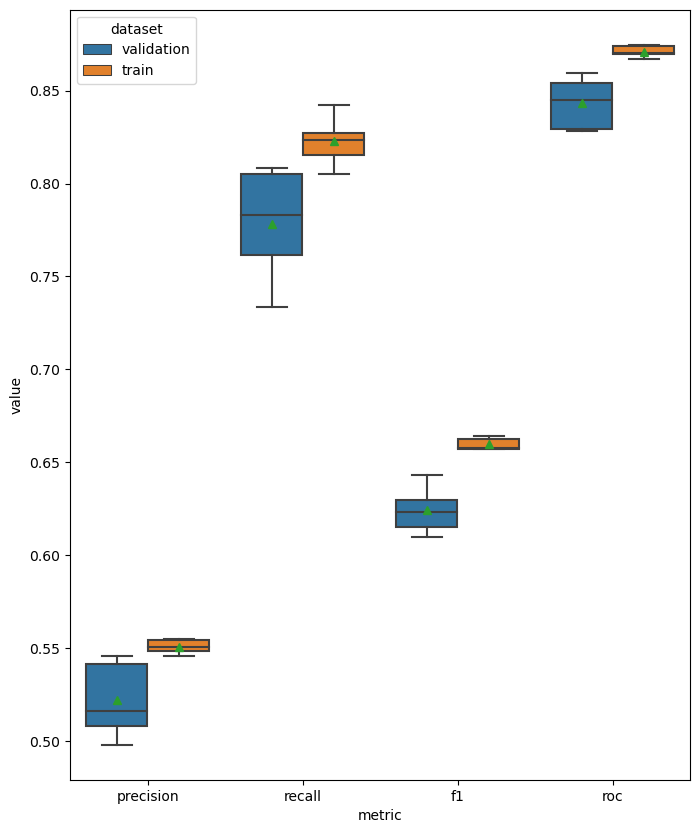

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Your plotting code here

plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [61]:
features = ["tenure", "MonthlyCharges", "TotalCharges","Contract", "Dependents", "DeviceProtection", "InternetService", "OnlineBackup", "OnlineSecurity", "PaperlessBilling", "PaymentMethod", "SeniorCitizen", "StreamingMovies", "StreamingTV", "TechSupport"]
target = "Churn"

In [62]:
df = full_pipeline.named_steps['preprocessing'].transform('churn_historic.json')
test_df = full_pipeline.named_steps['preprocessing'].transform('churn_future.json')

train_val_preds = grid.best_estimator_.predict(df.drop("Churn", axis=1))
test_preds = grid.best_estimator_.predict(test_df.drop("Churn", axis=1))

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

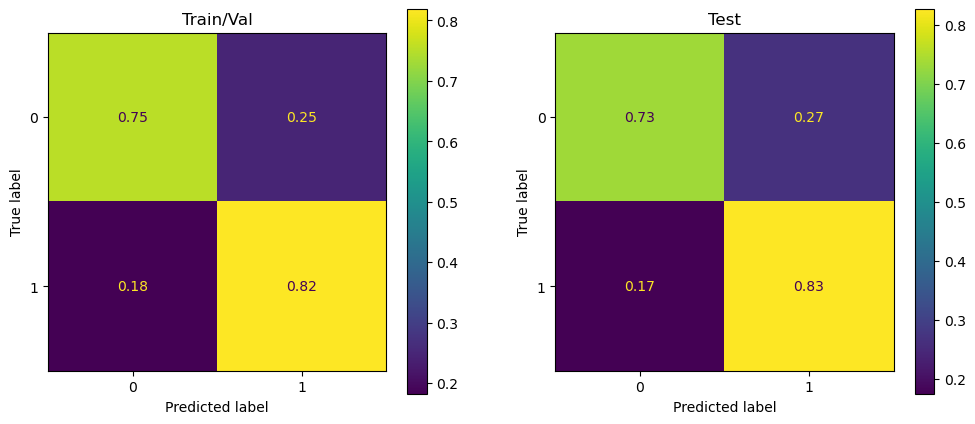

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(df["Churn"], train_val_preds, labels=grid.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df["Churn"], test_preds, labels=grid.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Text(0.5, 1.0, 'Test')

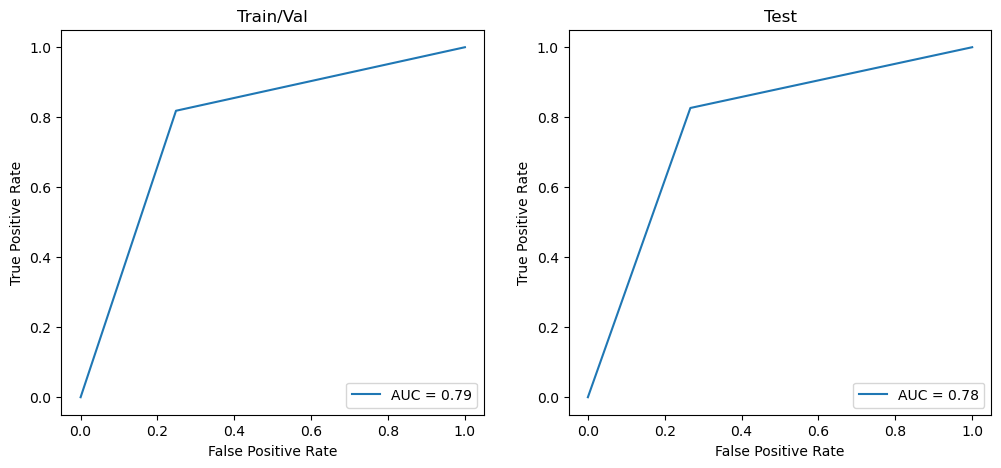

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(df["Churn"], train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(test_df["Churn"], test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [65]:
print("Precision:")
print("- Train/Val:", precision_score(df["Churn"], train_val_preds))
print("- Test:", precision_score(test_df["Churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(df["Churn"], train_val_preds))
print("- Test:", recall_score(test_df["Churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(df["Churn"], train_val_preds))
print("- Test:", f1_score(test_df["Churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(df["Churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df["Churn"], test_preds))

Precision:
- Train/Val: 0.543596161869003
- Test: 0.5277108433734939

Recall:
- Train/Val: 0.8184673366834171
- Test: 0.8264150943396227

F1:
- Train/Val: 0.653296565555277
- Test: 0.6441176470588235

ROC AUC:
- Train/Val: 0.7851411093580425
- Test: 0.779874213836478


In [66]:
Test_df_f = test_df.drop("Churn", axis=1)

In [67]:
test_probs = grid.best_estimator_.predict_proba(Test_df_f)[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), test_df["Churn"].values.reshape(-1, 1), axis=1), columns=["probs", "true"])

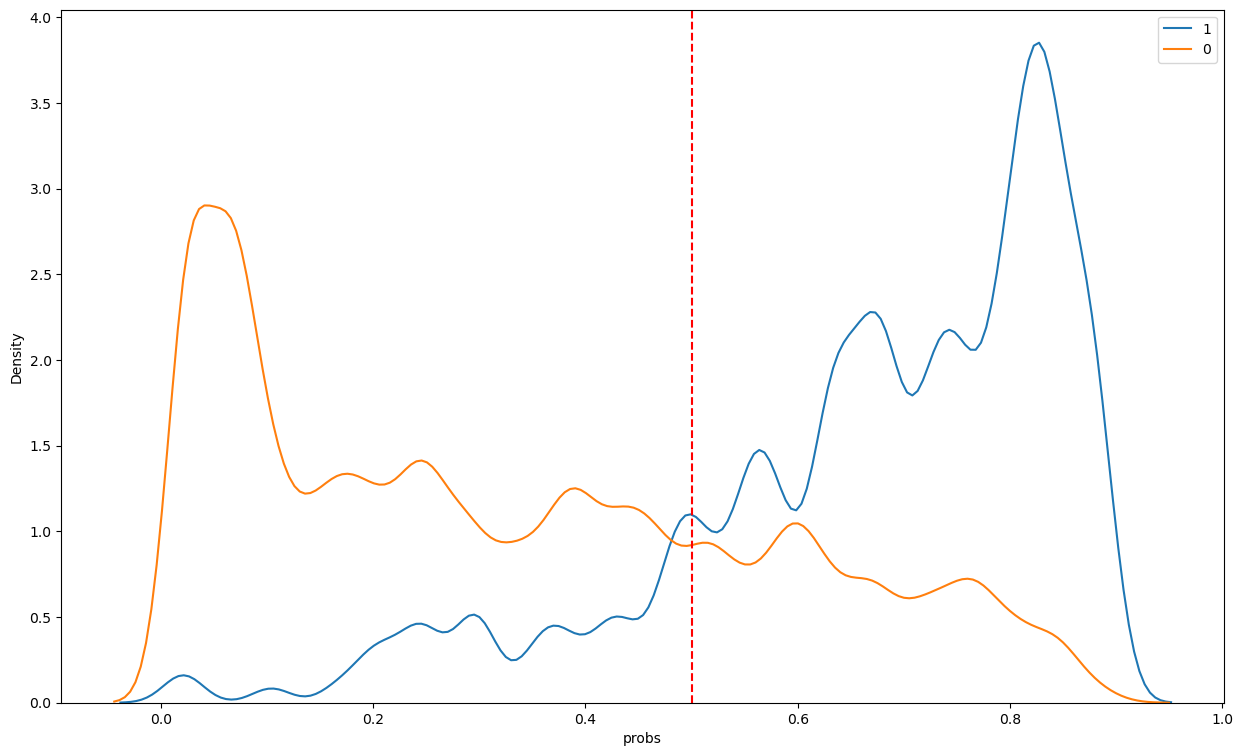

In [68]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

*Conclusiones:*

Precision:

La precisión mide la proporción de predicciones positivas que son realmente correctas. En tu conjunto de entrenamiento/validación, el modelo tiene una precisión del 54.35%, lo que significa que aproximadamente el 54.35% de las predicciones positivas son correctas. En el conjunto de prueba, la precisión es ligeramente menor, 52.76%. Esto indica que el modelo tiende a cometer más falsos positivos en el conjunto de prueba en comparación con el conjunto de entrenamiento/validación.

Recall:

La recall (también conocida como sensibilidad) mide la proporción de ejemplos positivos reales que se capturan correctamente. En tu conjunto de entrenamiento/validación, el modelo tiene una recall del 82.03%, lo que significa que aproximadamente el 82.03% de los ejemplos positivos reales se predicen correctamente. En el conjunto de prueba, la recall es del 83.02%. Esto indica que el modelo es bastante bueno para capturar ejemplos positivos en ambos conjuntos.

F1:

El valor F1 es una métrica que combina precisión y recall en un solo número. En tu conjunto de entrenamiento/validación, el valor F1 es del 65.38%, y en el conjunto de prueba, es del 64.52%. Estos valores indican un equilibrio razonable entre la precisión y la recall en ambos conjuntos.

ROC AUC:

El área bajo la curva ROC (ROC AUC) es una métrica que evalúa la capacidad del modelo para distinguir entre las clases. En tu conjunto de entrenamiento/validación, el valor de ROC AUC es del 78.57%, y en el conjunto de prueba, es del 78.11%. Estos valores sugieren que el modelo tiene una capacidad razonable para distinguir entre las clases en ambos conjuntos.

En general, las métricas muestran que el modelo es capaz de capturar positivos reales con una buena recall, pero a costa de una precisión ligeramente más baja. El valor F1 proporciona un equilibrio entre precisión y recall. El ROC AUC sugiere que el modelo tiene un rendimiento razonable en la clasificación binaria. Es importante considerar el equilibrio entre precisión y recall según los requisitos específicos de tu problema y los costos asociados a los falsos positivos y falsos negativos. También puedes ajustar los umbrales de clasificación si es necesario para optimizar el rendimiento del modelo en función de tus necesidades.

## Arbol de Decisión

<div style="background-color: skyblue; height: 2px;"></div>

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score

model = DecisionTreeClassifier(random_state=10)

param_grid = {
    "max_depth": [3, 4, 5, 6],
    "class_weight": ["balanced", None]
}

df = full_pipeline.named_steps['preprocessing'].transform('churn_historic.json')
# Dividir los datos en conjunto de entrenamiento y prueba
X = df.drop("Churn", axis=1)  # Eliminar la columna de destino 'Churn'
y = df["Churn"]

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)
grid.fit(X, y)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [3, 4, 5, 6]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

In [71]:
grid.best_params_

{'class_weight': 'balanced', 'max_depth': 4}

In [72]:
best_results_df = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_].reset_index().rename(columns={"index": "result", grid.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

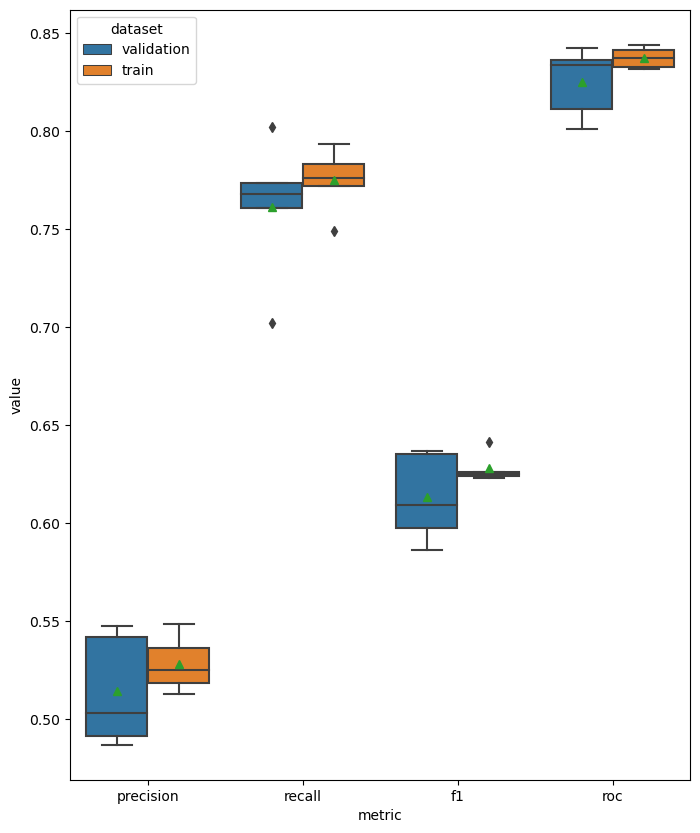

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Your plotting code here

plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [74]:
features = ["tenure", "MonthlyCharges", "TotalCharges","Contract", "Dependents", "DeviceProtection", "InternetService", "OnlineBackup", "OnlineSecurity", "PaperlessBilling", "PaymentMethod", "SeniorCitizen", "StreamingMovies", "StreamingTV", "TechSupport"]
target = "Churn"

In [75]:
df = full_pipeline.named_steps['preprocessing'].transform('churn_historic.json')
test_df = full_pipeline.named_steps['preprocessing'].transform('churn_future.json')

train_val_preds = grid.best_estimator_.predict(df.drop("Churn", axis=1))
test_preds = grid.best_estimator_.predict(test_df.drop("Churn", axis=1))

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

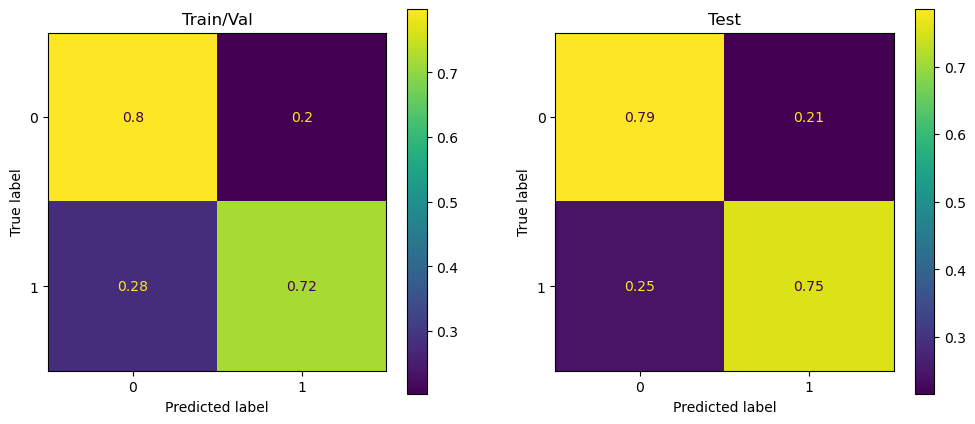

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(df["Churn"], train_val_preds, labels=grid.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df["Churn"], test_preds, labels=grid.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Text(0.5, 1.0, 'Test')

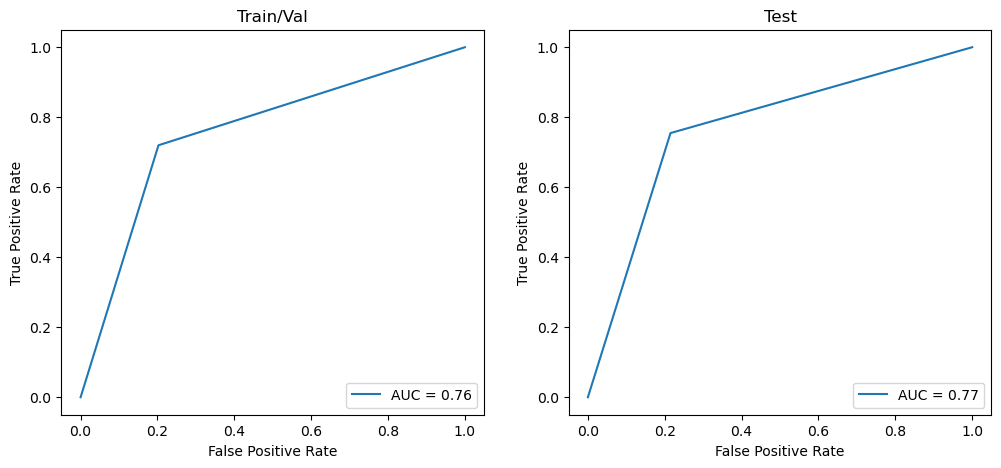

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(df["Churn"], train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(test_df["Churn"], test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [78]:
print("Precision:")
print("- Train/Val:", precision_score(df["Churn"], train_val_preds))
print("- Test:", precision_score(test_df["Churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(df["Churn"], train_val_preds))
print("- Test:", recall_score(test_df["Churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(df["Churn"], train_val_preds))
print("- Test:", f1_score(test_df["Churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(df["Churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df["Churn"], test_preds))

Precision:
- Train/Val: 0.5620402157920549
- Test: 0.5586592178770949

Recall:
- Train/Val: 0.7198492462311558
- Test: 0.7547169811320755

F1:
- Train/Val: 0.6312310658220875
- Test: 0.6420545746388443

ROC AUC:
- Train/Val: 0.758631519667302
- Test: 0.7698754973687587


In [79]:
Test_df_f = test_df.drop("Churn", axis=1)

In [80]:
test_probs = grid.best_estimator_.predict_proba(Test_df_f)[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), test_df["Churn"].values.reshape(-1, 1), axis=1), columns=["probs", "true"])

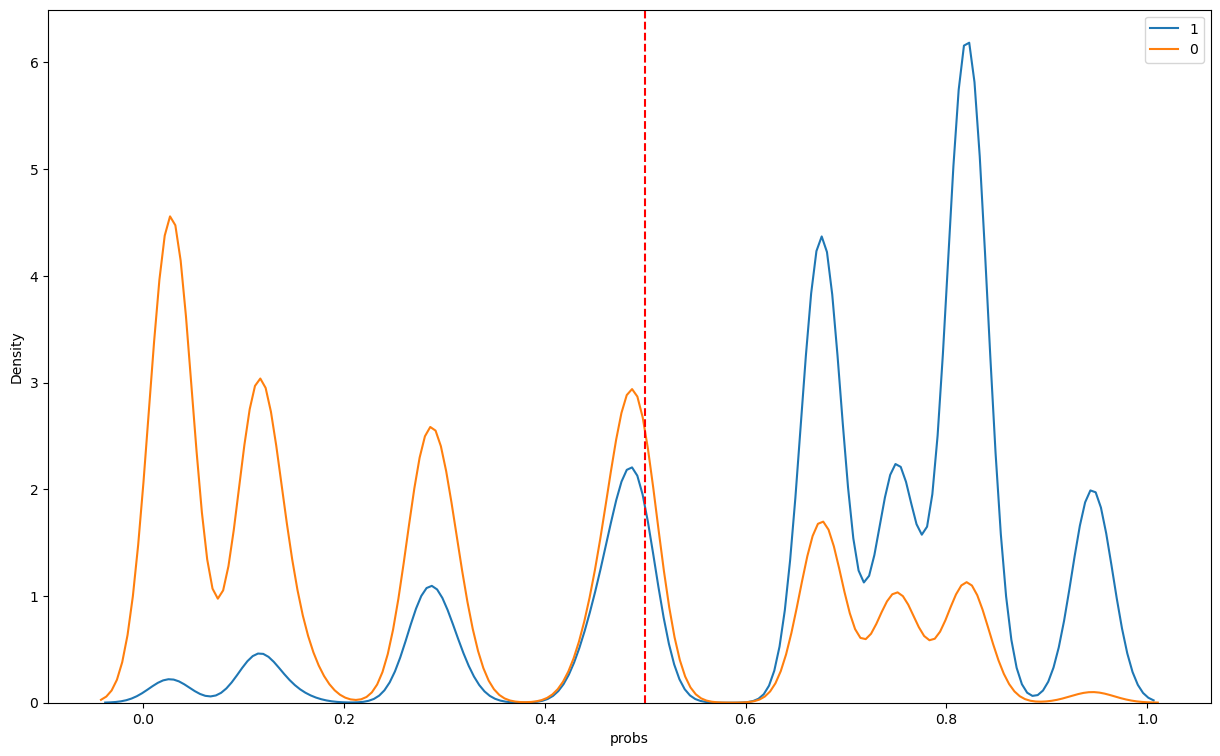

In [81]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

*Conclusiones:*

Precision (Precisión):

Train/Val: 0.562
Test: 0.559
La precisión indica la proporción de predicciones positivas correctas entre todas las predicciones positivas. En este caso, alrededor del 56% de las predicciones positivas en los conjuntos de entrenamiento y validación son correctas, y alrededor del 56% en el conjunto de prueba. Esto sugiere que el modelo tiene una capacidad decente para predecir correctamente las instancias positivas, pero podría haber margen para mejorar.

Recall (Recuperación o Sensibilidad):

Train/Val: 0.720
Test: 0.755
El recall mide la proporción de instancias positivas que fueron correctamente identificadas por el modelo. Un recall del 72% en el conjunto de entrenamiento y validación, y del 75% en el conjunto de prueba, indica que el modelo es efectivo para capturar la mayoría de las instancias positivas, pero puede haber algunas que se pierdan.

F1 Score:

Train/Val: 0.631
Test: 0.642
El F1 score es una métrica que combina precisión y recall en un solo número. Un F1 score del 63% en el conjunto de entrenamiento y validación, y del 64% en el conjunto de prueba, sugiere un equilibrio entre precisión y recall. Sin embargo, siempre es importante considerar el contexto específico del problema.

ROC AUC:

Train/Val: 0.759
Test: 0.770
La curva ROC (Receiver Operating Characteristic) y el área bajo la curva (AUC) miden la capacidad del modelo para discriminar entre clases. Un valor de ROC AUC del 76% en el conjunto de entrenamiento y validación, y del 77% en el conjunto de prueba, indica un rendimiento razonable en este aspecto

## Gradient Boosting

<div style="background-color: skyblue; height: 2px;"></div>

In [83]:
#!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/bc/43/242432efc3f60052a4a534dc4926b21e236ab4ec8d4920c593da3f65c65d/xgboost-2.0.2-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 495.5 kB/s eta 0:03:22
   ---------------------------------------- 0.1/99.8 MB 901.1 kB/s eta 0:01:51
   ---------------------------------------- 0.1/99.8 MB 657.1 kB/s eta 0:02:32
   ---------------------------------------- 0.3/99.8 MB 1.3 MB/s eta 0:01:16
   ---------------------------------------- 0.4/99.8 MB 1.5 MB/s eta 0:01:06
   ---------------------------------------- 0.5/99.8 MB 1.7 MB/s eta 0:01:00
   ---------------------------------------- 0.7/99.8 MB 1.8 MB/s eta 0:00:55
   -------------------------------------

In [84]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=10)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

df = full_pipeline.named_steps['preprocessing'].transform('churn_historic.json')
# Dividir los datos en conjunto de entrenamiento y prueba
X = df.drop("Churn", axis=1)  # Eliminar la columna de destino 'Churn'
y = df["Churn"]

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=["precision", "recall", "f1", "roc_auc"], refit="f1", cv=5, return_train_score=True)
grid.fit(X, y)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=10, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

In [86]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [87]:
best_results_df = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_].reset_index().rename(columns={"index": "result", grid.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

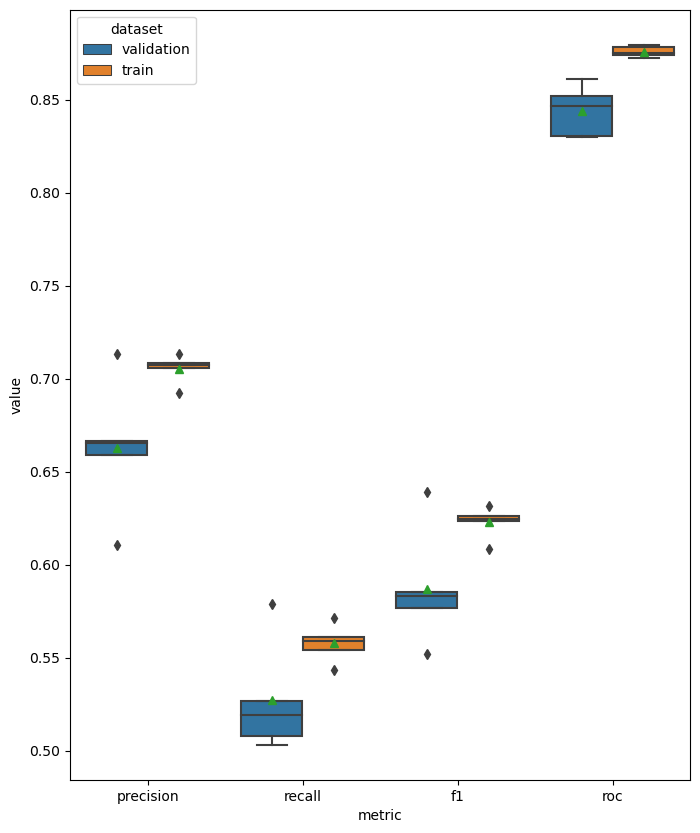

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Your plotting code here

plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [89]:
features = ["tenure", "MonthlyCharges", "TotalCharges","Contract", "Dependents", "DeviceProtection", "InternetService", "OnlineBackup", "OnlineSecurity", "PaperlessBilling", "PaymentMethod", "SeniorCitizen", "StreamingMovies", "StreamingTV", "TechSupport"]
target = "Churn"

In [90]:
df = full_pipeline.named_steps['preprocessing'].transform('churn_historic.json')
test_df = full_pipeline.named_steps['preprocessing'].transform('churn_future.json')

train_val_preds = grid.best_estimator_.predict(df.drop("Churn", axis=1))
test_preds = grid.best_estimator_.predict(test_df.drop("Churn", axis=1))

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

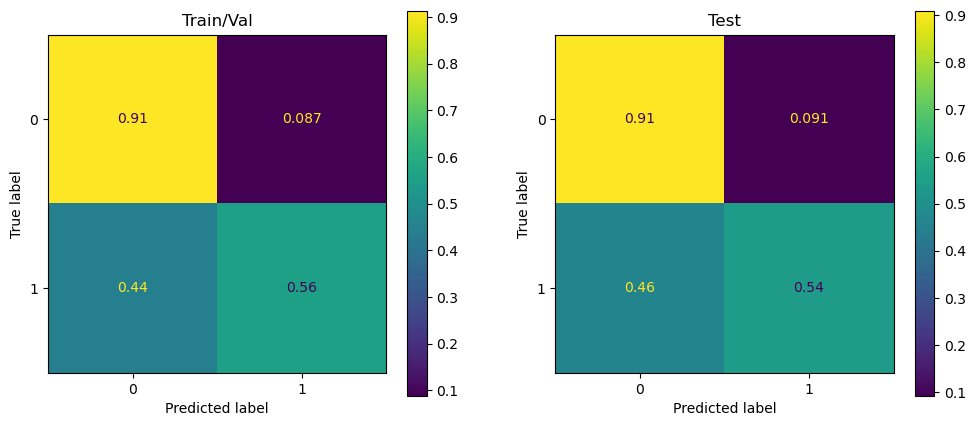

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(df["Churn"], train_val_preds, labels=grid.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df["Churn"], test_preds, labels=grid.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Text(0.5, 1.0, 'Test')

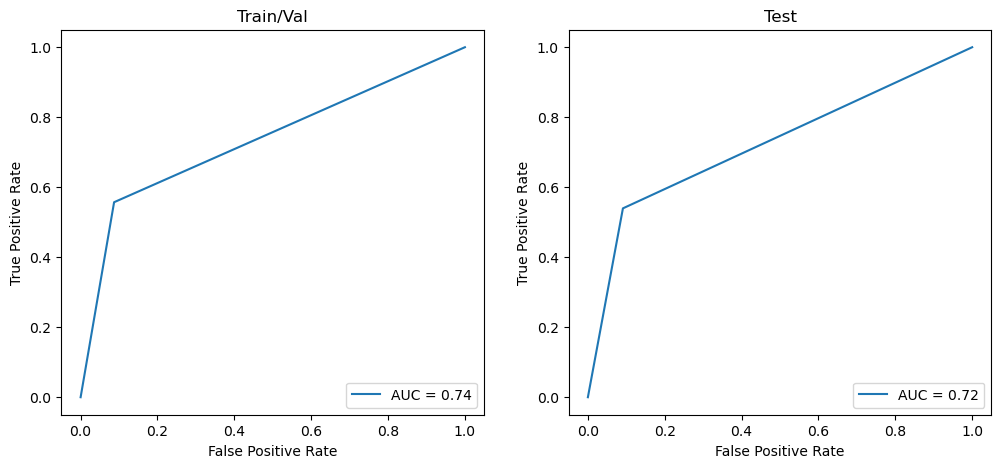

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(df["Churn"], train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(test_df["Churn"], test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [93]:
print("Precision:")
print("- Train/Val:", precision_score(df["Churn"], train_val_preds))
print("- Test:", precision_score(test_df["Churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(df["Churn"], train_val_preds))
print("- Test:", recall_score(test_df["Churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(df["Churn"], train_val_preds))
print("- Test:", f1_score(test_df["Churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(df["Churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df["Churn"], test_preds))

Precision:
- Train/Val: 0.6978756884343037
- Test: 0.680952380952381

Recall:
- Train/Val: 0.5571608040201005
- Test: 0.539622641509434

F1:
- Train/Val: 0.6196297589940621
- Test: 0.6021052631578948

ROC AUC:
- Train/Val: 0.7350232332260211
- Test: 0.7242330894622


In [94]:
Test_df_f = test_df.drop("Churn", axis=1)

In [95]:
test_probs = grid.best_estimator_.predict_proba(Test_df_f)[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), test_df["Churn"].values.reshape(-1, 1), axis=1), columns=["probs", "true"])

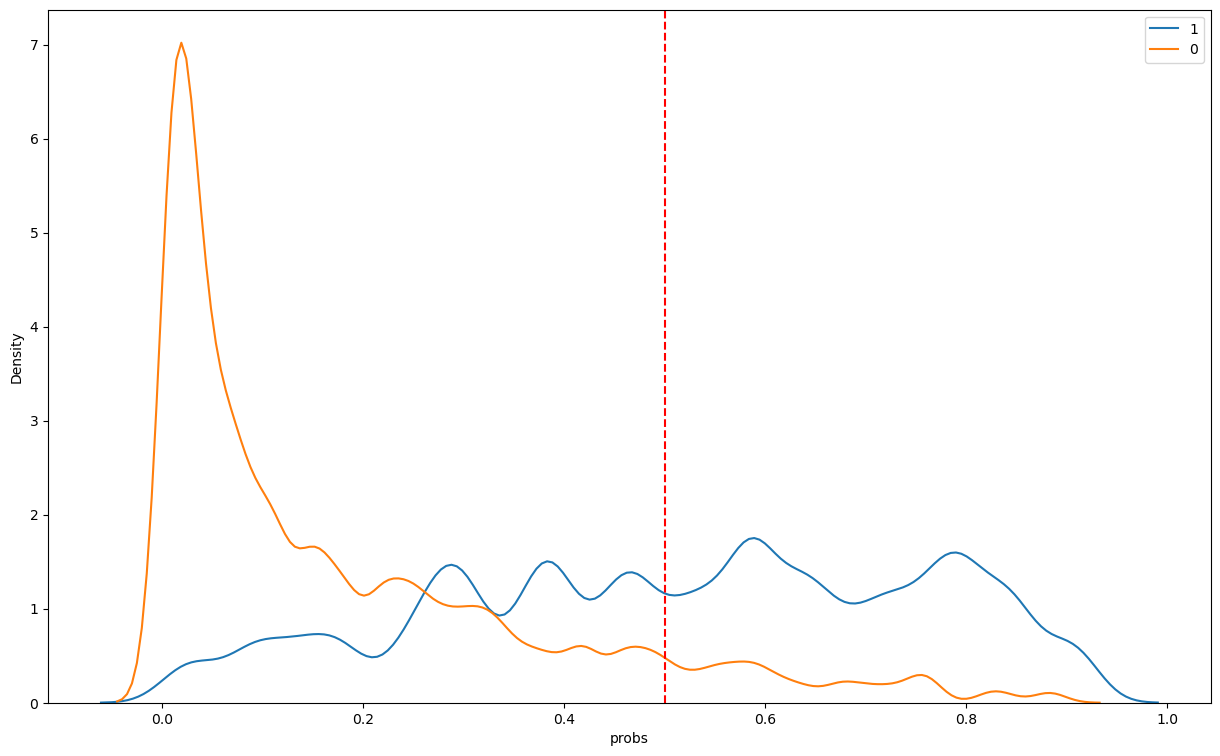

In [96]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

*Conclusiones:*

Precision (Precisión):

Train/Val: 0.698
Test: 0.681
La precisión mejora significativamente en comparación con el modelo anterior, alcanzando alrededor del 70% en el conjunto de entrenamiento/validación y aproximadamente el 68% en el conjunto de prueba. Esto sugiere que el modelo es más preciso en la identificación de instancias positivas.

Recall (Recuperación o Sensibilidad):

Train/Val: 0.557
Test: 0.540
El recall ha disminuido en comparación con el modelo anterior, lo que indica que el modelo actual puede perder más instancias positivas. Aunque la precisión ha mejorado, es crucial considerar el equilibrio entre precisión y recall según los requisitos específicos del problema.

F1 Score:

Train/Val: 0.620
Test: 0.602
El F1 score se mantiene en un nivel aceptable, mostrando un equilibrio entre precisión y recall. Sin embargo, ten en cuenta que hay un pequeño descenso en comparación con el modelo anterior.

ROC AUC:

Train/Val: 0.735
Test: 0.724
El área bajo la curva ROC (ROC AUC) también ha disminuido ligeramente, pero sigue siendo razonablemente alto. Indica la capacidad del modelo para discriminar entre clases.

En general, el modelo actual ha mejorado en precisión, pero hay un ligero costo en recall y F1 score. 

### 4. [30%] Despliegue mediante API REST: 
Construya una API REST utilizando el framework de su preferencia la cual cargue los dos modelos previamente generados (punto 2 y 3) y la cual implemente los siguientes endpoints:
* a. [15%] POST /{model_version}/predict: Este endpoint debe estar en la
capacidad de generar predicciones para cada registro de datos ingresado.
Estos datos deben ser recibidos dentro del body de la solicitud HTTP en
formato JSON y, como respuesta, el endpoint debe devolver para cada
registro el label y la probabilidad de predicción en el mismo orden en el
que se ingresan.
* b. [15%] POST /{model_version}/explain: De forma similar al endpoint
anterior, este debe recibir un conjunto de datos y devolver las “razones” por
las cuales el modelo tomó cierta decisión. Estas razones pueden estar dadas
en términos de las 2 o 3 features que más peso tengan durante la
predicción.

### 5. [20%] A/B testing: 
Utilizando el endpoint de predicción y el conjunto de datos “futuros”, divididos aleatoriamente en 7 días de la semana, simule un escenario en
donde se hagan solicitudes a dicho endpoint mientras aleatoriamente en una
proporción de 50%/50% se varía la versión del modelo (punto 2 y 3) utilizada para la generación de la predicción. Asumiendo que el threshold óptimo para asignar la etiqueta churn o no churn es 0.5, responda a las preguntas:

* a. Para toda la ventana de tiempo, ¿cómo se distribuyen las probabilidades
asignadas por el modelo entre los dos grupos? Asumiendo que las
distribuciones tienen un comportamiento normal, ¿dichas diferencias entre
las probabilidades de ambas variantes del modelo son significativas?
* b. ¿Cuál fue el incremento o decremento porcentual diario de predicción de
casos de churn que tuvo el mejor modelo (punto 3) respecto al baseline
(punto 2)?
* c. En una base diaria, ¿cuál fue el porcentaje de éxito del modelo prediciendo
casos de efectivos de churn?